## 1. Preparation
Load dataset and import some packages. The data is already clean, so there is not much work to do with data cleaning. 

`reviews_dict`: the dictionary for all words appear in all reviews

`reviews_bow`: serialized corpus in Market Matrix format 

`reviews_times`: time of reviews 

`y`: ratings 

 

In [0]:
# install stuff
%%capture
!pip install -U gensim
!pip install urllib2

In [0]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf

import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from datetime import *
from operator import itemgetter



In [0]:
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

In [0]:
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

Convert counts in `reviews_bow` to tf-idf score 

In [0]:
def make_tfidf(reviews_bow):
  tfidf_model = TfidfModel(reviews_bow, normalize= True)
  
  return tfidf_model[reviews_bow]


In [0]:
reviews_tfidf = make_tfidf(reviews_bow)

## 2. Basic Analysis 

### Analysis about number of words in reviews

I want to look at the number of words in reviews. I think this could be insightful when I train classification models in later sections. 

First, I calculate the average number of words in all reviews. It is about 43.64639. 

Then, I draw a histogram for the distribution of number of words in reviews. It turns out that very few reviews have more than 100 words. 

In [0]:
def get_avgLength(reviews_bow):
  total = 0
  n = len(reviews_bow)
  for review in reviews_bow:
    for word in review:
      total += word[1]
  return total/n

In [0]:
avg_length = get_avgLength(reviews_bow)
print(avg_length)

43.64639


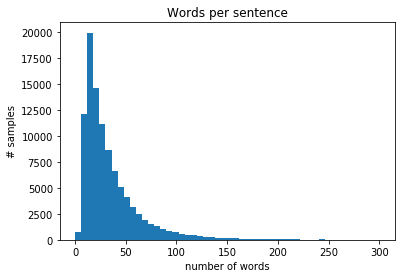

In [0]:
plt.hist([len(review) for review in reviews_bow], bins=50, range=(0, 300))
plt.title('Words per sentence')
plt.xlabel('number of words')
plt.ylabel('# samples')
plt.show()

### Text Frenquency Analysis

In this section, I try to get some information about the most frequent words for each star ratings.

`look_indices (y, val)`: get the indices for the reviews whose rating == val

`get_dict`: create a dictionary for rating == val, in which each word index is paired with its frequency 

`d1, d2, d3, d4, d5` are frequency dictionary for star rating 1, 2, 3, 4, 5

`word1, word2, word3, word4, word5` are most frequent 20 words in each star rating



In [0]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [0]:
def look_indices(y, val):
  indices = []
  for i in range(len(y)):
    if y[i] == val:
      indices.append(i)
  return indices

def get_dict(reviews, y, val, dict):
  indices = look_indices(y, val)
  d = {}
  for i in indices:
    for word in reviews[i]:
      keyInd = word[0]
      key = dict[keyInd]
      cnt = word[1]
      if key in d:
        d[key] += cnt
      else:
        d[key] = 1 
  return d

def draw_WordCloud(d):
  wordcloud = WordCloud(background_color='white')
  wordcloud.generate_from_frequencies(frequencies=d)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

In [0]:
x = np.array(reviews_bow) #Convert reviews_bow to np.array 
d1 = get_dict(x, y, 1, reviews_dict)
d2 = get_dict(x, y, 2, reviews_dict)
d3 = get_dict(x, y, 3, reviews_dict)
d4 = get_dict(x, y, 4, reviews_dict)
d5 = get_dict(x, y, 5, reviews_dict)



In [0]:
word1 = sorted(d1, key=d1.get, reverse=True)[:20] 
word2 = sorted(d2, key=d2.get, reverse=True)[:20] 
word3 = sorted(d3, key=d3.get, reverse=True)[:20] 
word4 = sorted(d4, key=d4.get, reverse=True)[:20] 
word5 = sorted(d5, key=d5.get, reverse=True)[:20] 

I draw Word Clouds for reviews of each star ratings and also get 20 most frequency in each rating level. 

By the plots and words, I found out that products related to pets (dogs and cats) and babies are more likely to get negative reviews (1 star or 2 stars). We can infer that product categories may have some effects on ratings 

1 star


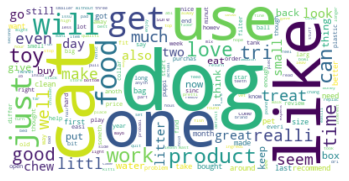

2 star


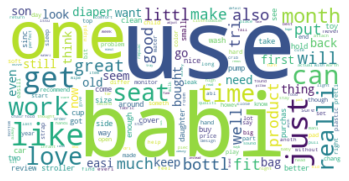

3 star


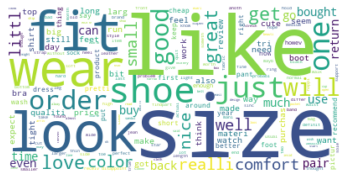

4 star


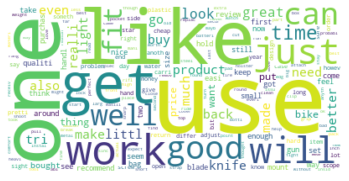

5 star


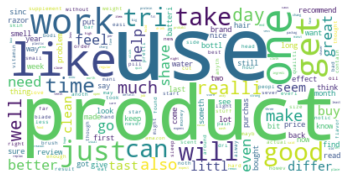

In [0]:
print("1 star")
draw_WordCloud(d1)
print("2 star")
draw_WordCloud(d2)
print("3 star")
draw_WordCloud(d3)
print("4 star")
draw_WordCloud(d4)
print("5 star")
draw_WordCloud(d5)


In [0]:
print("Most Frequent Words in 1 star reviews:\n", word1)
print("Most Frequent Words in 2 star reviews:\n", word2)
print("Most Frequent Words in 3 star reviews:\n", word3)
print("Most Frequent Words in 4 star reviews:\n", word4)
print("Most Frequent Words in 5 star reviews:\n", word5)

Most Frequent Words in 1 star reviews:
 ['dog', 'cat', 'one', 'like', 'use', 'get', 'just', 'will', 'food', 'product', 'work', 'can', 'toy', 'love', 'time', 'tri', 'good', 'well', 'realli', 'treat']
Most Frequent Words in 2 star reviews:
 ['use', 'babi', 'one', 'like', 'get', 'just', 'can', 'work', 'seat', 'love', 'time', 'realli', 'month', 'great', 'will', 'littl', 'bottl', 'also', 'much', 'well']
Most Frequent Words in 3 star reviews:
 ['size', 'like', 'look', 'fit', 'wear', 'shoe', 'just', 'one', 'order', 'will', 'good', 'get', 'great', 'love', 'realli', 'comfort', 'color', 'well', 'small', 'nice']
Most Frequent Words in 4 star reviews:
 ['use', 'one', 'like', 'get', 'work', 'just', 'will', 'good', 'can', 'well', 'fit', 'time', 'great', 'look', 'product', 'make', 'knife', 'need', 'go', 'realli']
Most Frequent Words in 5 star reviews:
 ['use', 'product', 'like', 'one', 'work', 'get', 'just', 'tri', 'good', 'will', 'take', 'can', 'time', 'realli', 'well', 'day', 'much', 'make', 'also'

## 3. Time Series Analysis
In this section, I conduct Time Series Analysis on ratings to see if time has any effects on ratings 

In [0]:
def convert_times(reviews_times):
  time = np.vectorize(datetime.fromtimestamp)
  time1 = time(reviews_times)
  time2 = pd.DataFrame(time1)
  return time2[0]

In [0]:
converted_times = convert_times(reviews_times)
y_df = pd.Series(y)
df = pd.concat([converted_times, y_df], axis=1)
df.columns = ['Time', 'Ratings']
df = df.set_index('Time')
ts = df['Ratings']

From the Yearly plot, we can see that the average ratings from 2004 to 2008 has a huge leap, and since 2008, the flucatuation of average ratings becomes gradual

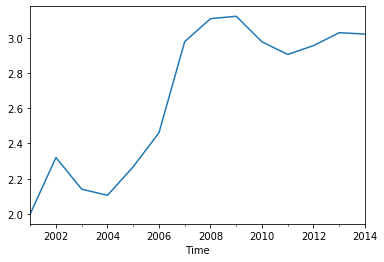

In [0]:
years = ts.groupby(pd.Grouper(freq = 'A')).mean()
years.plot()

From the monthly plot, we can see that the average ratings before 2009 change very robustly, and become smooth after 2009. 

Although there are some insights we can get from time, but as the number of reviews received in the same day is huge and due to the robust and unstable change, I don't think add reviews_time to my models would help much.

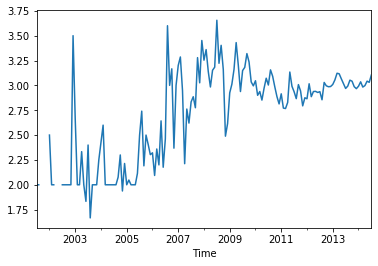

In [0]:
months = ts.groupby(pd.Grouper(freq = 'M')).mean()
months.plot()

### PCA on tf-idf scores 


In this step, I just conduct the PCA and densify the results to prepare for later analysis 

In [0]:
def densify(sparse, columns):
    # TODO #
    result = np.zeros((len(sparse), columns))
    i = 0
    for doc in sparse:
      for j in range(len(doc)):
        result[i][doc[j][0]] = doc[j][1]
      i = i + 1
    return result 

In [0]:
max_cutoff = 40
model = LsiModel(reviews_tfidf, id2word=reviews_dict, num_topics=max_cutoff)
X = densify(model[reviews_tfidf], len(model.projection.s))

##4. Some Simple Classifiers

In this section, I tried two simple classifiers: 

1.   Decision Tree Classifier 
2.   XGBoost Classifier
3.   Linear Support Vector Machine (SVM) 

I use the same training and testing datasets for all three classifier. 

`X`: is from the last step - PCA scores on tf-idf

`y`: is the star rating loaded from the beginning 


In [0]:
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [0]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state = 22222)


### Decision Tree

Decision Tree is a relatively simple and interpretable classifier. The accurary of this decision tree classifier is 0.61445, which is not bad but not so good. But one advantage of decision tree is it is easy to see exactly how decisions are made (which is shown by the graph).

In [0]:
dt_clf = DecisionTreeClassifier(max_depth=4)
dt_clf.fit(x_train1, y_train1)
dt_pred = dt_clf.predict(x_test1)

In [0]:
print(accuracy_score(y_test1, dt_pred))

0.6099


In [0]:
print(classification_report(y_test1, dt_pred))

              precision    recall  f1-score   support

           1       0.95      0.59      0.73      4046
           2       0.73      0.53      0.61      3969
           3       0.74      0.71      0.72      3967
           4       0.38      0.69      0.49      3953
           5       0.61      0.53      0.57      4065

    accuracy                           0.61     20000
   macro avg       0.68      0.61      0.62     20000
weighted avg       0.68      0.61      0.62     20000



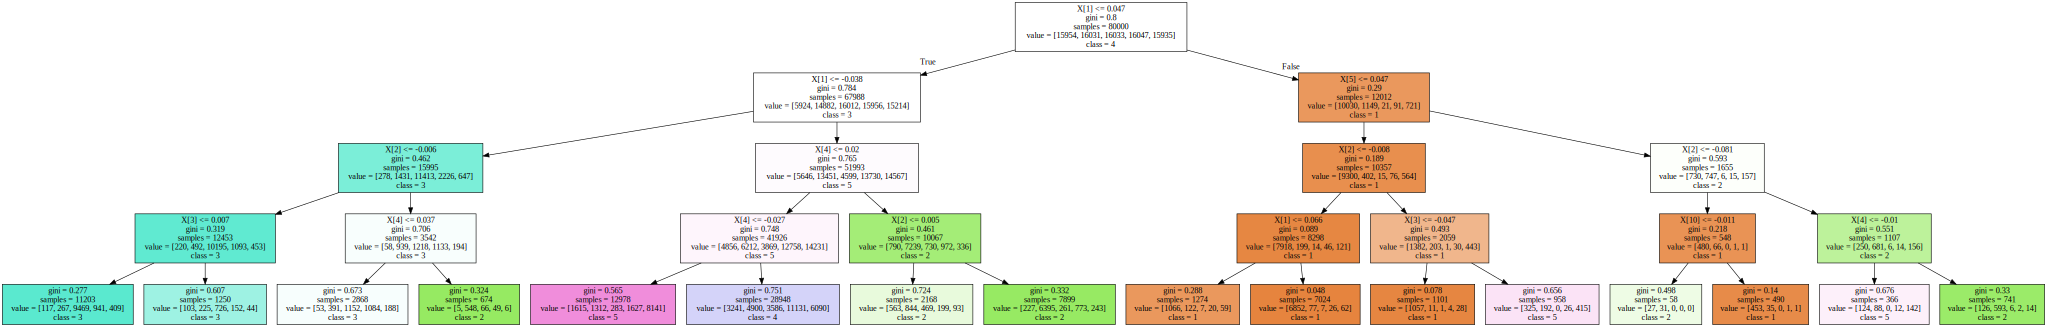

In [0]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
graph = Source(
    tree.export_graphviz(
        dt_clf,
        out_file=None,
        class_names=['1', '2', '3', '4', '5'],
        filled = True)
)
display(SVG(graph.pipe(format='svg')))

### XGBoost

To improve the results I got from Decision Tree, I implement XGBoost Classifier, which is a version of gradient boosted decision tree classifier. Its scalability drives fast learning through parallel and distributed computing and offers efficient memory usage. 

From the same training and testing dataset, the accuracy increases to 0.784

In [0]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(x_train1, y_train1)
xgb_pred = xgb_clf.predict(x_test1)

In [0]:
print(accuracy_score(y_test1, xgb_pred))

0.78495


In [0]:
print(classification_report(y_test1, xgb_pred))

              precision    recall  f1-score   support

           1       0.91      0.80      0.85      4046
           2       0.82      0.80      0.81      3969
           3       0.77      0.86      0.81      3967
           4       0.69      0.71      0.70      3953
           5       0.75      0.75      0.75      4065

    accuracy                           0.78     20000
   macro avg       0.79      0.78      0.79     20000
weighted avg       0.79      0.78      0.79     20000



### SVM

I learned from Internet Support vector machines (SVM) is a popular method that perform well on text classification tasks. SVM is an algorithm that determines the best decision boundary between vectors that belong to a given group (or category) and vectors that do not belong to it.

I use LinearSVC from sklearn libary. I tried this linear kernal, because text is often linearly separable and in text classification, both the numbers of instances (document) and features (words) are large. Linear kerrnal is easier to implement and usually the performance won't be bad. This could provide a baseline for me to search for better performance. 

The accuracy of this classifier is nearly 0.80. It beats Decision Tree and XGBoost

In [0]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state = 22222)
classifier1 = LinearSVC(random_state = 22222, tol=1e-5)
classifier1.fit(x_train1, y_train1)
preds1 = classifier1.predict(x_test1)

In [0]:
print(accuracy_score(y_test1, preds1))

0.7974


In [0]:
print(classification_report(y_test1, preds1))

              precision    recall  f1-score   support

           1       0.92      0.81      0.86      4046
           2       0.82      0.83      0.83      3969
           3       0.78      0.86      0.82      3967
           4       0.73      0.72      0.72      3953
           5       0.75      0.77      0.76      4065

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000



### Summary 

From the classification reports of all three classifiers, we can see that the accuracy of prediction of 1 star reviews is most accurate, and that of 4 or 5 stars reviews is less accurate. This is true in real life. When people give 1 star, they usually very angry and dispointted and use a lot of bitter words. Those are easier to detect. However, 4 or 5 rating reviews are similar. There is only very subtle difference in the levels of likeness, which could be harder to be detected by machines, even by human. 

## 5. Neuron Network Models 

In this section, I want to improve the performance from last section, so I decide to try some neuron network models. 

### Preparation 

In [0]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D
from keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Embedding, LSTM, GRU


Using TensorFlow backend.



**transform_x**: transform mmcorpus format to a nparray of integer list. The integers are the index of words in reviews_dict 



> For example: review in reviews_bow would be like: [(1, 1,0), (2, 2.0), (3, 3.0), ...]. By runing transform_x, it will be like [1, 2, 2, 3, 3, 3, ...]

**tranform_y**: tranform y into a nparray within 5 columns to represent a categorical data 

> For example: ([1., 0., 0., 0., 0.]) indicates a 1 star ratings 



In [0]:
def transform_x(x_sample):
  list = []
  i = 0
  while i < len(x_sample):
    x = []
    j = 0
    while (j < len(x_sample[i])):
      n = 0
      while n < x_sample[i][j][1]:

        x.append(x_sample[i][j][0])
        n += 1
      j += 1
    i += 1
    list.append(x)
  return np.array(list) 

def transform_y(y_sample):
  arr = np.zeros((len(y_sample), 5))
  i = 0
  while i < len(y_sample):
    arr[i][y_sample[i]-1] = 1
    i+=1
  return arr


In [0]:
 x = np.array(reviews_bow)
 x_modified = transform_x(x)
 y_modified = transform_y(y)


## CNN Model

Inspired from the Image Classifier, I tried a CNN model on text classification as well. 

Architecture 
*   Embedding Layer: it represents words in a coordinate system where related words, based on a corpus of relationships, are placed closer together. 
*   Conv1D: this will learn NUM_FILTERS filters
* Dropout: add dropout to overcome overfitting 
* Vanilla Hidden Layer: with HIDDEN_DIMS
* Fully Connected Layer:  takes the deep representation deep network and transforms it into the final output classes or class scores.
* Output Layer (softmax): I use softmax because it is a multi-claasification problem 

Model Parameters - I tuned these parameter several times and these generate the most accurate result I tried so far


*   VOCAB_SIZE: is settled as the size of the reviews_dict 

*   MAX_LENGTH: is the length of reviews I look at. In step 1, I got the average reviews is about 40 words about most revies are under 100 words, so I tuned 
this parameter between 40 - 100 

*   EMBEDDING_DIM: most common EMBEDDING_DIM is 50, 100, 300, so I tried among those three 

*   NUM_FILTERS, KERNEL_SIZE, HIDDEN_DIMS: I have tried some popular settings in deep learning 









In [0]:

MAX_LENGTH = 80
VOCAB_SIZE = len(reviews_dict)
EMBEDDING_DIM = 100
NUM_FILTERS = 256 
KERNEL_SIZE = 3 
HIDDEN_DIMS = 256

In [0]:
x_pad = pad_sequences(x_modified, maxlen = MAX_LENGTH ,padding = 'post', value = 0)
x_train, x_test, y_train, y_test = train_test_split(x_pad, y_modified, test_size=0.2, random_state = 42)

In [0]:
#test2 CNN
cnn_model = Sequential()
cnn_model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length = MAX_LENGTH))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(NUM_FILTERS, KERNEL_SIZE, padding='valid', activation='relu', strides = 1))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(HIDDEN_DIMS))
cnn_model.add(Dropout(0.2))
cnn_model.add(Activation('relu'))
cnn_model.add(Dense(5))
cnn_model.add(Activation('softmax'))
cnn_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
cnn_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 100)           1871600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 80, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 78, 256)           77056     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 256)              

The Model always reaches 0.87 accuracy after 2 or 3 epoches, and then start overfitting. So I set epochs = 5 here to show the best result. 

In [0]:
cnn_model.fit(x_train, y_train, batch_size=128, epochs = 5, validation_data=(x_test, y_test), verbose=1)

Train on 80000 samples, validate on 20000 samples
Epoch 1/5
80000/80000 [==============================] - 98s 1ms/step - loss: 0.5864 - acc: 0.7874 - val_loss: 0.3938 - val_acc: 0.8652
Epoch 2/5
80000/80000 [==============================] - 97s 1ms/step - loss: 0.3089 - acc: 0.8954 - val_loss: 0.3745 - val_acc: 0.8712
Epoch 3/5
80000/80000 [==============================] - 96s 1ms/step - loss: 0.2217 - acc: 0.9253 - val_loss: 0.4120 - val_acc: 0.8670
Epoch 4/5
80000/80000 [==============================] - 96s 1ms/step - loss: 0.1603 - acc: 0.9455 - val_loss: 0.4616 - val_acc: 0.8623
Epoch 5/5
80000/80000 [==============================] - 95s 1ms/step - loss: 0.1180 - acc: 0.9597 - val_loss: 0.5288 - val_acc: 0.8575


### Gated Recurrent Unit (GRU)

I learned that RNN is a good method for text classfication problem, and GRU is a newer version of RNN, so I try this method on the reviews classification 

Architecture: 


*   Embedding Layer: it represents words in a coordinate system where related words, based on a corpus of relationships, are placed closer together. 
*   GRU: this is my deep network. It takes the sequence of embedding vectors as input and converts them to a compressed representation. 
* Fully Connected Layer (Dense):  takes the deep representation from the GRU and transforms it into the final output classes or class scores.
* Output Layer (softmax): I use softmax because it is a multi-claasification problem 

Prarmeters: 


* VOCAB_SIZE: is settled as the size of the reviews_dict

* MAX_LENGTH: is the length of reviews I look at. In step 1, I got the average reviews is about 40 words about most revies are under 100 words, so I tuned this parameter between 40 - 100

* EMBEDDING_DIM: most common EMBEDDING_DIM is 50, 100, 300, so I tried among those three

* GRU_UNITS: I have tried some popular settings in deep learning




In [0]:
# 0.86 4 epochs 
MAX_LENGTH = 80
VOCAB_SIZE = len(reviews_dict)
EMBEDDING_DIM = 100
GRU_UNITS = 64 


In [0]:
x_pad = pad_sequences(x_modified, maxlen = MAX_LENGTH ,padding = 'post', value = 0)
x_train, x_test, y_train, y_test = train_test_split(x_pad, y_modified, test_size=0.2, random_state = 42)

In [0]:
 
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length = MAX_LENGTH))
model.add(Dropout(0.2))
model.add(GRU(units = GRU_UNITS, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 100)           1871600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 80, 100)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                31680     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 1,903,605
Trainable params: 1,903,605
Non-trainable params: 0
_________________________________________________________________


The Model reaches 0.86 accuracy in 3 or 4 epochs, so I set epoches = 5 

In [0]:
model.fit(x_train, y_train, batch_size=128, epochs = 5, validation_data=(x_test, y_test), verbose=1)

Train on 80000 samples, validate on 20000 samples
Epoch 1/5
80000/80000 [==============================] - 109s 1ms/step - loss: 1.2099 - acc: 0.4712 - val_loss: 0.7206 - val_acc: 0.7675
Epoch 2/5
80000/80000 [==============================] - 109s 1ms/step - loss: 0.5401 - acc: 0.8248 - val_loss: 0.4745 - val_acc: 0.8446
Epoch 3/5
80000/80000 [==============================] - 108s 1ms/step - loss: 0.3874 - acc: 0.8752 - val_loss: 0.4303 - val_acc: 0.8598
Epoch 4/5
80000/80000 [==============================] - 111s 1ms/step - loss: 0.3211 - acc: 0.8964 - val_loss: 0.4272 - val_acc: 0.8610
Epoch 5/5
80000/80000 [==============================] - 111s 1ms/step - loss: 0.2805 - acc: 0.9095 - val_loss: 0.4308 - val_acc: 0.8587


### Summary 

Both the CNN model and GRU model reach relatively high accuracy around 86% ~ 87%, and this is only intro-level trial of neuron network models. Neuron Networks Models perform better for complicated problem like this. 

And to further improve the models in the future, maybe we can try to combine the CNN and GRU together, or try other interesting models such as BiLSTM. 